In [9]:
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.path.abspath(''))))

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from src.Config import Config as cfg
import cv2
#import nibabel as nib  # For handling NIfTI format commonly used in medical imaging

In [11]:
#define folders for input
cfg.TRAINING_FOLDER = os.path.join(cfg.BASE_DIR, 'Training')
cfg.TESTING_FOLDER = os.path.join(cfg.BASE_DIR, 'Testing')
cfg.VAL_FOLDER = os.path.join(cfg.BASE_DIR, 'Validation')

CLASSES = sorted([cls for cls in os.listdir(cfg.TRAINING_FOLDER) if cls != '.DS_Store'])
print(CLASSES)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [14]:
folders = os.listdir(cfg.TRAINING_FOLDER)
images = []
image_shapes = []
for folder in folders:
  folder_path = os.path.join(cfg.TRAINING_FOLDER, folder)
  for path in os.listdir(folder_path):
    image_path = os.path.join(os.path.join(cfg.TRAINING_FOLDER, folder), path)
    image = cv2.imread(image_path)
    
    # Convert to RGB as OpenCV uses BGR
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    images.append(image)
    
    # Obtain shape of each image and store them in an array
    (width, height) = image.shape[1], image.shape[0]
    image_shapes.append((width, height))
    
# Return only unique shapes
unique_shapes = list(set(image_shapes))


### Check the size of the images

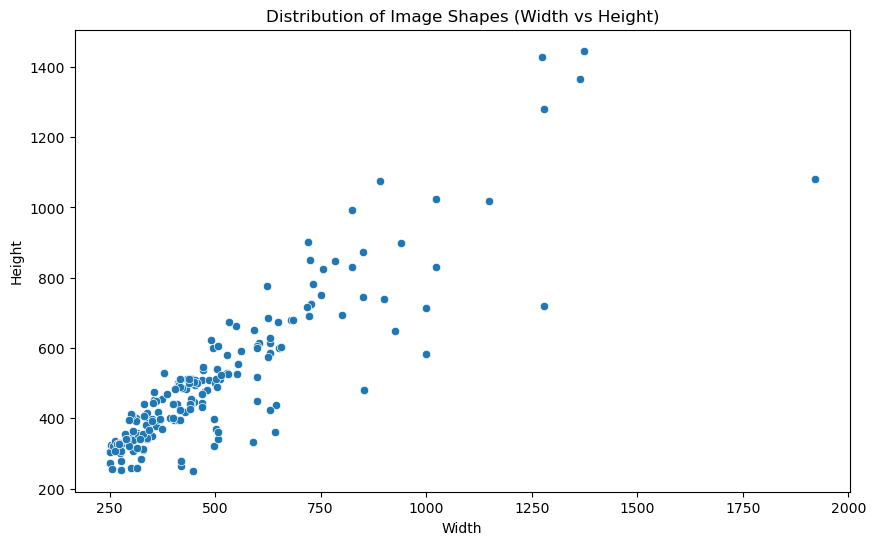

In [15]:
#image size of the training dataset 
#CNNs like VGG-16 usually take in images of fixed shape like (224, 224, 3)  
for shape in unique_shapes:
  if shape[0] > 250 and shape[1] > 250:
    #print(shape)

# Plotting the distribution of image shapes
    filtered_shapes = [shape for shape in unique_shapes if shape[0] > 250 and shape[1] > 250]

plt.figure(figsize=(10, 6))
sns.scatterplot(x=[shape[0] for shape in filtered_shapes], y=[shape[1] for shape in filtered_shapes])
plt.title("Distribution of Image Shapes (Width vs Height)")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()



### Check the blurriness of the images
(how is effecting blurness for training of the model)
check it out without optimisation

In [17]:

def calculate_blurriness(image):
  # Convert the image to grayscale
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Calculate the Laplacian variance as a measure of blurriness
  laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()

  return laplacian_var

def is_blurry(image, threshold=100):
  # Determine if the image is blurry based on a threshold
  blurriness = calculate_blurriness(image)
  return blurriness < threshold

# create map of blurriness values
blurList = []

# Load an image
for folder in folders:
  folder_path = os.path.join(cfg.TRAINING_FOLDER, folder)
  for path in os.listdir(folder_path):
    image_path = os.path.join(os.path.join(cfg.TRAINING_FOLDER, folder), path)
    image = cv2.imread(image_path)
    
    # Check blurriness
    blurriness = calculate_blurriness(image)
    blurList.append(blurriness)
    #print("Blurriness:", blurriness)

    threshold_value = 100
    blurry = is_blurry(image, threshold_value)
    #print("Is blurry?", blurry)

blurArray = np.array(blurList)

mean_blur = np.mean(blurArray)
median_blur = np.median(blurArray)
std_blur = np.std(blurArray)
min_blur = np.min(blurArray)
max_blur = np.max(blurArray)

print(f"Mean Blurriness: {mean_blur:.2f}")
print(f"Median Blurriness: {median_blur:.2f}")
print(f"Standard Deviation: {std_blur:.2f}")
print(f"Minimum Blurriness: {min_blur:.2f}")
print(f"Maximum Blurriness: {max_blur:.2f}")



Mean Blurriness: 1138.11
Median Blurriness: 69.15
Standard Deviation: 4241.75
Minimum Blurriness: 5.69
Maximum Blurriness: 48617.35


The mean and median blurriness give us an overview of the general quality of images. A high mean blurriness, especially when there is a significant difference between the mean and the median, suggests that while most images may have reasonable sharpness (lower blurriness), there are a significant number of very blurry images skewing the average higher.

The very high maximum blurriness value, coupled with a high standard deviation, indicates the presence of outliers—extremely blurry images.These outliers can be problematic as they might not only degrade the performance of the models by acting as noise but could also affect the training process by introducing bias.

In [26]:
# Otsu's method is a form of dynamic thresholding, as it automatically adapts to the local characteristics of an image. This is particularly useful when images have varying lighting conditions. Otsu's method assumes that the image contains two classes of pixels: foreground and background, and then calculates the optimal threshold separating these two classes so that their combined spread (intra-class variance) is minimal. This threshold can then be used to convert a grayscale image to a binary one.

def calculate_blurriness(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def find_optimal_threshold(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_image

# Load an image
image_path = r"D:\Thesis\Project_Brain Tumor\brain_tumor_ml\data\processed\Training\glioma\Tr-gl_0026.jpg"
img = cv2.imread(image_path)

if img is None:
    print("Failed to load image")
else:
    print("Image loaded successfully")

# Calculate blurriness
blurriness = calculate_blurriness(img)

# Convert the image to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find optimal threshold using Otsu's method
threshold, binary_image = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Display the results
cv2.imshow("Original Image", img)
cv2.imshow("Binary Image (Otsu's Method)", binary_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Image loaded successfully


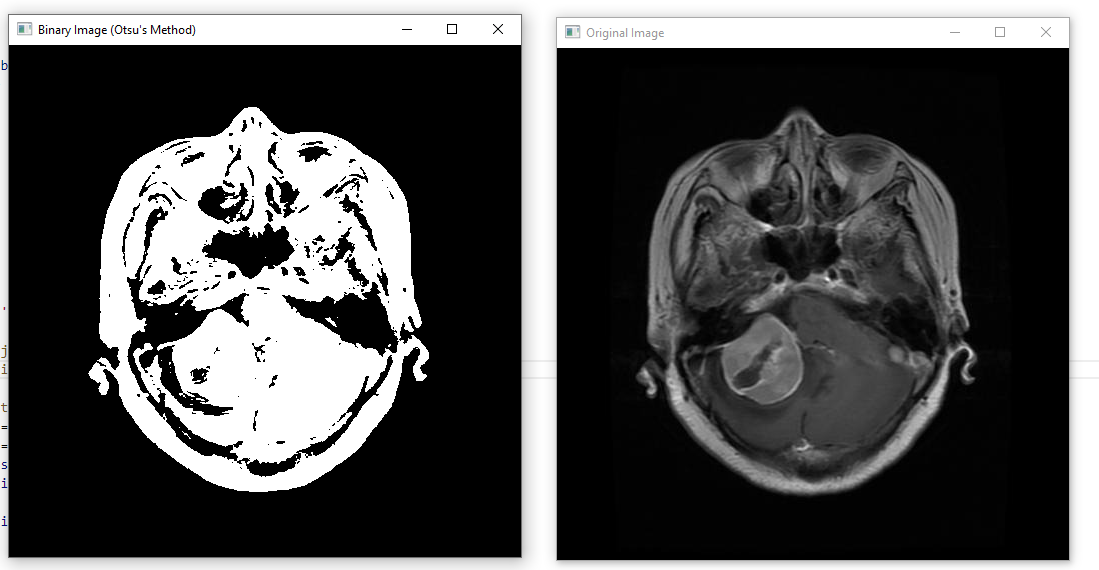

In complex medical images like MRIs, tumors might not distinctly differ in grayscale intensity from surrounding tissues, leading Otsu’s method to produce oversimplified results that merge tumor regions with healthy tissues or exclude parts of tumors.

### Check class imbalance Training

In [30]:
# check how many images in the each folder
for folder in folders:
  folder_path = os.path.join(cfg.TRAINING_FOLDER, folder)
  print(f"{folder}: {len(os.listdir(folder_path))}")

glioma: 1321
meningioma: 1333
notumor: 1422
pituitary: 1445
